In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.vision.gan import *
from urllib.parse import urlparse
import torch.nn as nn
import torch.nn.functional as F
import copy
import inspect

In [0]:
def debuginfo(stack_pos=1):
    caller = inspect.getframeinfo(inspect.stack()[stack_pos][0])
    print("%s:%d" % (caller.filename, caller.lineno))

In [0]:
def is_listy_or_tensor_array(l): 
  try:
    return is_listy(l) or (l.dim() > 0)
  except:
    return False

def compare_lists(l1, l2):
  "Prints the indexes where the input lists differ. Assumes l1 and l2 are lists, which may contain tensors"
  _compare_lists_recursive(l1, l2)
  
def _compare_lists_recursive(l1, l2, indexes=[], list_accesor = lambda l, i: l[i]):
  "Assumes l1 and l2 are lists"
  if len(l1) != len(l2):
    print('Length varies with indexes = ', indexes)
  is_top_level = indexes==[]
  for i in range(len(l1)):
    if is_top_level: print('iteration ', i)
    l1_i = list_accesor(l1, i)
    l2_i = list_accesor(l2, i)
    if is_listy_or_tensor_array(l1_i) and is_listy_or_tensor_array(l2_i):
        indexes.append(i)
        compare_lists(l1_i, l2_i, indexes)
        indexes.pop()
    elif is_listy_or_tensor_array(l1_i) or is_listy_or_tensor_array(l2_i):
        print('Type mismatch (list vs no-list) in ', indexes, i)
    elif (l1_i.data != l2_i.data):
        print(f'Difference in {indexes},{i} with l1 = {l1_i} and l2 = {l2_i}')

# DATA

In [4]:
realImagesPath = untar_data("http://vis-www.cs.umass.edu/lfw/lfw-a")
realImagesPath

PosixPath('/root/.fastai/data/lfw-a')

In [0]:
# For whatever reason the "-a" isn't included in the folder name by tarfile.extractall
realImagesPath = realImagesPath.parent/'lfw'

In [0]:
sampleImg1Path = realImagesPath/'Aaron_Eckhart/Aaron_Eckhart_0001.jpg'

In [7]:
from PIL import Image

im = Image.open(sampleImg1Path)
im.size

(250, 250)

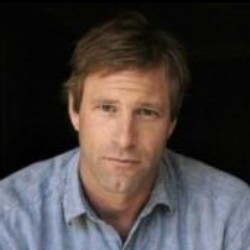

In [8]:
from IPython.display import Image
Image(filename=str(sampleImg1Path))


GANItemList stores NoisyItem's in x and the input images in y (target)

In [0]:
def get_data(path, bs, size, stats):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               #.transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .transform(tfms=[[], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = stats, do_x=False, do_y=True))

# CRITIC

In [0]:
# PLATFORM DEPENDENT CODE !!!!
def mount_gdrive():
  root_dir = '/content'

  if (importlib.util.find_spec("google.colab") is not None):
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    root_dir = "/content/gdrive/My Drive/"
  
  return root_dir

In [0]:
def get_critic_pkl_dir():
  # Replace with code to get pkl from your source
  root_dir = mount_gdrive()
  rel_path = 'ML/'
  return root_dir + rel_path

Load a pretrained discriminator. Pending research about whether it's good to start with a pretrained one, kind of more knolewdgeable than the generator.

In [0]:
def load_critic():
  return load_learner(get_critic_pkl_dir(), 'faceBinaryClassifierResnet18_1.pkl')

critic = load_critic()

In [0]:
critic.data.tfms

[functools.partial(<function _normalize_batch at 0x7ff56e960598>, mean=tensor([0.4775, 0.4546, 0.4104]), std=tensor([0.2616, 0.2614, 0.2744]), do_x=True, do_y=False)]

In [0]:
critic_stats = [torch.tensor([0.4775, 0.4546, 0.4104]), torch.tensor([0.2616, 0.2614, 0.2744])]

In [0]:
def loadNewTestImage(url: str, filename: str, testRootDir:Path):
  parsedUrl = urlparse(url)
  ext = os.path.splitext(parsedUrl.path)[1]
  path = testRootDir/(filename + ext)
  download_url(url, path)
  img = open_image(path)
  return img

Fastai managed image, stored as a Tensor with values in [0..1]

In [0]:
img = loadNewTestImage('https://live.staticflickr.com/3844/14761664536_f875cf6b9c_b.jpg', 'fakeFace', Path('/content'))
img

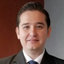

In [0]:
img = loadNewTestImage('https://i1.rgstatic.net/ii/profile.image/679664246865925-1539055992441_Q64/Leonardo_Glasserman.jpg', 'realFace64x64', Path('/content'))
img

Predict automatically resizes input image to 224x224 before making the forward pass

In [0]:
critic.predict(img)

(Category positive, tensor(1), tensor([3.4406e-12, 1.0000e+00]))

---
Manually evaluate an input of size 64x64. This shouldn't be right, as it seems minimum input size expected is 224x224

In [0]:
batch_one_item = img._px.unsqueeze(0)
batch_one_item.size(), critic.model(batch_one_item)#, F.softmax(critic.model(batch_one_item), dim=-1)

(torch.Size([1, 3, 64, 64]),
 tensor([[-8.7864,  0.5899]], grad_fn=<AddmmBackward>))

In [0]:
??critic.data.single_ds.set_item
??critic.predict
??critic.data.one_item
#   ??critic.data.single_ds.set_item
#   ??critic.data.single_ds.x.process_one
#   ??critic.data.single_ds.x.processor
??critic.data.one_batch
??critic.data.train_dl

---
Getting the predictions for a size 1 batch

In [0]:
batch1 = critic.data.one_item(img) # creates a size 1 batch; previously resizes image to 224x224, so it's (1, 3, 224, 224)
result1 = critic.pred_batch(batch=batch1)
result1, batch1[0].size()
# predictions return are the result of grab_idx(result1, 0, batch_first=True). grab_idx just takes the predictions for batch passed (0 here), indexed according to batch_first
# ??critic.predict


(tensor([[3.4406e-12, 1.0000e+00]]), torch.Size([1, 3, 224, 224]))

---
Stuff called from learner.pred_batch, used here for deeper understanding of the details

In [0]:
loss_func_name2activ = {'cross_entropy_loss': F.softmax, 'nll_loss': torch.exp, 'poisson_nll_loss': torch.exp,
    'kl_div_loss': torch.exp, 'bce_with_logits_loss': torch.sigmoid, 'cross_entropy': F.softmax,
    'kl_div': torch.exp, 'binary_cross_entropy_with_logits': torch.sigmoid,
}

def _loss_func_name2activ(name:str, axis:int=-1):
    res = loss_func_name2activ[name]
    if res == F.softmax: res = partial(F.softmax, dim=axis)
    return res

def _loss_func2activ(loss_func):
    if getattr(loss_func,'keywords',None):
        if not loss_func.keywords.get('log_input', True): return
    axis = getattr(loss_func, 'axis', -1)
    # flattened loss
    loss_func = getattr(loss_func, 'func', loss_func)
    # could have a partial inside flattened loss! Duplicate on purpose.
    loss_func = getattr(loss_func, 'func', loss_func)
    cls_name = camel2snake(loss_func.__class__.__name__)
    if cls_name == 'mix_up_loss':
        loss_func = loss_func.crit
        cls_name = camel2snake(loss_func.__class__.__name__)
    if cls_name in loss_func_name2activ:
        if cls_name == 'poisson_nll_loss' and (not getattr(loss_func, 'log_input', True)): return
        return _loss_func_name2activ(cls_name, axis)
    if getattr(loss_func,'__name__','') in loss_func_name2activ:
        return _loss_func_name2activ(loss_func.__name__, axis)
    return noop

---

Manually getting the activations for the model of the critic (not proper way to do it)

In [0]:
??critic.pred_batch
# pred_batch does...
# preds = loss_batch(self.model.eval(), xb, yb, cb_handler=cb_handler)
#      out = model(xb)
#      return loss_func(out, yb)
# res = _loss_func2activ(self.loss_func)(preds[0])
# return res

In [0]:
xb, yb = batch1
out1 = critic.model(xb)
# critic.loss_func(out1, yb)
lf1 = _loss_func2activ(critic.loss_func) # softmax
lf1(out1)

tensor([[3.4406e-12, 1.0000e+00]], grad_fn=<SoftmaxBackward>)

---
Playing with softmax...

In [0]:
t1 = Tensor([[2, -2, 1], [-20, -20, 3]])
# dim = 0 -> first dimension, dim = 1 -> second dimension, ...; dim = -1 -> last dimension
softmaxDim0 = F.softmax(t1, dim=0)
softmaxDim1 = F.softmax(t1, dim=1) 
softmaxDimMinus1 = F.softmax(t1, dim=-1)
softmaxDim0, softmaxDim1, softmaxDimMinus1

(tensor([[1.0000e+00, 1.0000e+00, 1.1920e-01],
         [2.7895e-10, 1.5230e-08, 8.8080e-01]]),
 tensor([[7.2140e-01, 1.3213e-02, 2.6539e-01],
         [1.0262e-10, 1.0262e-10, 1.0000e+00]]),
 tensor([[7.2140e-01, 1.3213e-02, 2.6539e-01],
         [1.0262e-10, 1.0262e-10, 1.0000e+00]]))

---
Calling transforms manually (again, just a test, not proper way to do it)

In [0]:
t1 = torch.Tensor(1)
t1[0] = 3.5
# Add dimension of size 1 (like wrapping aaa in another vector)
t1.unsqueeze_(0)
t1.size()
t2 = None
# batch1 = critic.data.one_item(img)
for f in listify(critic.data.tfms): t2 = f(batch1)
t1, t1.size(), t2

(tensor([[3.5000]]),
 torch.Size([1, 1]),
 (tensor([[[[-4.8497, -4.8497, -4.8497,  ..., -3.0478, -3.0316, -3.0154],
            [-4.8497, -4.8452, -4.8406,  ..., -3.0316, -3.0154, -2.9992],
            [-4.8497, -4.8406, -4.8314,  ..., -3.0154, -2.9992, -2.9831],
            ...,
            [-4.7127, -4.7451, -4.7775,  ..., -7.5340, -7.5389, -7.5438],
            [-4.8099, -4.8423, -4.8747,  ..., -7.5065, -7.5252, -7.5438],
            [-4.9071, -4.9394, -4.9718,  ..., -7.4791, -7.5115, -7.5438]],
  
           [[-7.0723, -7.0723, -7.0723,  ..., -2.5703, -2.5541, -2.5379],
            [-7.0723, -7.0677, -7.0632,  ..., -2.5541, -2.5379, -2.5216],
            [-7.0723, -7.0632, -7.0540,  ..., -2.5379, -2.5216, -2.5054],
            ...,
            [-4.5718, -4.6113, -4.6507,  ..., -7.0050, -7.0100, -7.0149],
            [-4.5880, -4.6321, -4.6761,  ..., -6.9776, -6.9962, -7.0149],
            [-4.6042, -4.6528, -4.7015,  ..., -6.9501, -6.9825, -7.0149]],
  
           [[-6.4260, -6.426

# GENERATOR

In [14]:
#Testing a transpose convolution
input = torch.rand(64, 100, 1, 1)
nn.ConvTranspose2d(100, 1024, 4, padding=0, stride=1)(input).size()

torch.Size([64, 1024, 4, 4])

In [0]:
class ConvTransBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvTransBlock, self).__init__()
    self.conv = nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, (4, 4), padding=1, stride=2),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    )
    
  def forward(self, x):
    return self.conv(x)

class GeneratorNet(nn.Module):
  def __init__(self):
    super(GeneratorNet, self).__init__()
    self.layers = nn.Sequential(
      #nn.Linear(100, 1024 * 4 * 4),
      nn.ConvTranspose2d(100, 1024, 4, padding=0, stride=1),
      ConvTransBlock(1024, 512),
      ConvTransBlock(512, 256),
      ConvTransBlock(256, 128),
      #ConvTransBlock(128, 64)
      nn.ConvTranspose2d(128, 3, 4, padding=1, stride=2),
      nn.Tanh()
    )

  def forward(self, x):
    # x = x.view(1024, 4, 4) Use it when putting FC at the beginning
    x = self.layers(x)
    return x

In [16]:
#Testing a forward pass through the generator
input = torch.rand(64, 100, 1, 1)
output = GeneratorNet()(input)
output.size()

torch.Size([64, 3, 64, 64])

# GAN LEARNER

In [0]:
# GANLearner(
#     data:DataBunch, 
#     generator:Module, 
#     critic:Module, 
#     gen_loss_func:LossFunction, 
#     crit_loss_func:LossFunction, 
#     switcher:Callback=None, 
#     gen_first:bool=False, 
#     switch_eval:bool=True, 
#     show_img:bool=True, 
#     clip:float=None, 
#     **learn_kwargs) :: Learner

In [0]:
def gan_loss_from_func(loss_gen, loss_crit, inner_loss_crit, weights_gen:Tuple[float,float]=None):
    activation = _loss_func2activ(inner_loss_crit)
  
    "Define loss functions for a GAN from `loss_gen` and `loss_crit`."
    def _loss_G(fake_pred, output, target, weights_gen=weights_gen):
        ones = fake_pred.new_ones(fake_pred.shape[0])
        weights_gen = ifnone(weights_gen, (1.,1.))
        if activation:
          fake_pred = activation(fake_pred)
    
        result = weights_gen[0] * loss_crit(fake_pred[:, 1], ones) + weights_gen[1] * loss_gen(output, target)
      
        return result

    def _loss_C(real_pred, fake_pred):
        ones  = real_pred.new_ones (real_pred.shape[0])
        zeros = fake_pred.new_zeros(fake_pred.shape[0])

        if activation:
          real_pred = activation(real_pred)
          fake_pred = activation(fake_pred)
          
        result = (loss_crit(real_pred[:, 1], ones) + loss_crit(fake_pred[:, 1], zeros)) / 2
        
        return result

    return _loss_G, _loss_C

---
Code copied from fastai for debugging purposes


In [0]:
class CustomGANModule(Module):
    "Wrapper around a `generator` and a `critic` to create a GAN."
    def __init__(self, generator:nn.Module=None, critic:nn.Module=None, gen_mode:bool=False):
        self.gen_mode = gen_mode
        if generator: self.generator,self.critic = generator,critic

    def forward(self, *args):
        result = self.generator(*args) if self.gen_mode else self.critic(*args)
        return result

    def switch(self, gen_mode:bool=None):
        "Put the model in generator mode if `gen_mode`, in critic mode otherwise."
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode

class CustomGANLoss(CustomGANModule):
    "Wrapper around `loss_funcC` (for the critic) and `loss_funcG` (for the generator)."
    def __init__(self, loss_funcG:Callable, loss_funcC:Callable, gan_model:GANModule):
        super().__init__()
        self.loss_funcG,self.loss_funcC,self.gan_model = loss_funcG,loss_funcC,gan_model

    def generator(self, output, target):
        "Evaluate the `output` with the critic then uses `self.loss_funcG` to combine it with `target`."
        fake_pred = self.gan_model.critic(output)
        return self.loss_funcG(fake_pred, target, output)

    def critic(self, real_pred, input):
        "Create some `fake_pred` with the generator from `input` and compare them to `real_pred` in `self.loss_funcD`."
        fake = self.gan_model.generator(input.requires_grad_(False)).requires_grad_(True)
        fake_pred = self.gan_model.critic(fake)
        return self.loss_funcC(real_pred, fake_pred)
      
class CustomGANLearner(Learner):
    "A `Learner` suitable for GANs."
    def __init__(self, data:DataBunch, generator:nn.Module, critic:nn.Module, gen_loss_func:LossFunction,
                 crit_loss_func:LossFunction, switcher:Callback=None, gen_first:bool=False, switch_eval:bool=True,
                 show_img:bool=True, clip:float=None, **learn_kwargs):
        gan = CustomGANModule(generator, critic)
        loss_func = CustomGANLoss(gen_loss_func, crit_loss_func, gan)
        switcher = ifnone(switcher, partial(FixedGANSwitcher, n_crit=5, n_gen=1))
        super().__init__(data, gan, loss_func=loss_func, callback_fns=[switcher], **learn_kwargs)
        trainer = CustomGANTrainer(self, clip=clip, switch_eval=switch_eval, show_img=show_img)
        self.gan_trainer = trainer
        self.callbacks.append(trainer)

    @classmethod
    def from_learners(cls, learn_gen:Learner, learn_crit:Learner, switcher:Callback=None,
                      weights_gen:Tuple[float,float]=None, **learn_kwargs):
        "Create a GAN from `learn_gen` and `learn_crit`."
        losses = gan_loss_from_func(learn_gen.loss_func, learn_crit.loss_func, weights_gen=weights_gen)
        return cls(learn_gen.data, learn_gen.model, learn_crit.model, *losses, switcher=switcher, **learn_kwargs)

    @classmethod
    def wgan(cls, data:DataBunch, generator:nn.Module, critic:nn.Module, switcher:Callback=None, clip:float=0.01, **learn_kwargs):
        "Create a WGAN from `data`, `generator` and `critic`."
        return cls(data, generator, critic, NoopLoss(), WassersteinLoss(), switcher=switcher, clip=clip, **learn_kwargs)
      

---

**INITIALIZATION OF LEARNER**

In [0]:
data = get_data(realImagesPath, 64, 64, critic_stats) # CAMBIAR 1 POR 64 o INCLUSO BORRAR AQUÍ Y DEJAR SOLO ARRIBA
generator = GeneratorNet()
#losses = gan_loss_from_func(learn_gen.loss_func, learn_crit.loss_func, weights_gen=weights_gen)
# weights_gen might be useful when using an additional loss function for the generator
# weights_gen[0]=weight for "standard" loss function (comparing ones with D(G(z)))
# weights_gen[1]= weights for results of extra loss function)

# No extra func for gen, only log(D(G(z)))
losses = gan_loss_from_func(lambda *args: 0, nn.BCELoss(), critic.loss_func) 

learner = GANLearner(
  data,
  generator,
  critic.model,
  *losses)
#opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.



---



I've found out that critic gets bad at recognizing faces (its original purpose) after only 1 epoch with really small learning rate. Maybe it's caused by batch norm stats. Let's try to guess the reason.

In [0]:
original_params = copy.deepcopy(list(learner.model.critic.parameters()))

In [0]:
def eval_one_real_batch_critic():
# CLEAN WAY (not working for the moment)  
#   old_gen_mode = learner.model.gen_mode
#   print(old_gen_mode)
#   learner.model.switch(gen_mode=False)
#   preds = learner.pred_batch(ds_type=DatasetType.Train)
#   learner.model.switch(old_gen_mode)
#   return preds

# DIRTY WAY (internals)  
  learner.model.critic.eval()
  for xb,yb in learner.data.train_dl:
    print(F.softmax(learner.model.critic(yb), dim=-1))
    break

Let's check the critic is predicting well

In [0]:
eval_one_real_batch_critic()

tensor([[3.5624e-05, 9.9996e-01],
        [7.5429e-07, 1.0000e+00],
        [5.6001e-03, 9.9440e-01],
        [4.4974e-07, 1.0000e+00],
        [2.5440e-05, 9.9997e-01],
        [6.5207e-08, 1.0000e+00],
        [1.7770e-03, 9.9822e-01],
        [1.1391e-08, 1.0000e+00],
        [2.5613e-07, 1.0000e+00],
        [2.3990e-05, 9.9998e-01],
        [1.0560e-08, 1.0000e+00],
        [3.1891e-07, 1.0000e+00],
        [2.5844e-05, 9.9997e-01],
        [2.6801e-05, 9.9997e-01],
        [8.7349e-10, 1.0000e+00],
        [4.4948e-03, 9.9551e-01],
        [4.8718e-07, 1.0000e+00],
        [4.5945e-06, 1.0000e+00],
        [2.2939e-08, 1.0000e+00],
        [2.0060e-05, 9.9998e-01],
        [4.6745e-07, 1.0000e+00],
        [6.5943e-11, 1.0000e+00],
        [1.0801e-05, 9.9999e-01],
        [1.5942e-04, 9.9984e-01],
        [9.8936e-07, 1.0000e+00],
        [9.7948e-09, 1.0000e+00],
        [4.6118e-11, 1.0000e+00],
        [3.8989e-04, 9.9961e-01],
        [6.1476e-08, 1.0000e+00],
        [1.400

First check if just a change (and back to eval) of mode has an effect over predictions

In [0]:
learner.model.critic.train()
learner.model.critic.eval()
eval_one_real_batch_critic()

tensor([[2.0535e-06, 1.0000e+00],
        [1.4396e-07, 1.0000e+00],
        [3.0514e-04, 9.9969e-01],
        [1.7077e-03, 9.9829e-01],
        [5.7350e-07, 1.0000e+00],
        [7.3138e-07, 1.0000e+00],
        [6.6935e-08, 1.0000e+00],
        [2.9718e-09, 1.0000e+00],
        [6.3680e-06, 9.9999e-01],
        [2.6064e-08, 1.0000e+00],
        [2.2567e-04, 9.9977e-01],
        [1.1459e-07, 1.0000e+00],
        [2.8817e-04, 9.9971e-01],
        [1.7417e-07, 1.0000e+00],
        [4.6004e-06, 1.0000e+00],
        [1.6104e-06, 1.0000e+00],
        [1.1686e-08, 1.0000e+00],
        [7.8406e-06, 9.9999e-01],
        [4.1376e-09, 1.0000e+00],
        [1.0389e-07, 1.0000e+00],
        [1.6584e-03, 9.9834e-01],
        [1.2677e-05, 9.9999e-01],
        [3.4985e-08, 1.0000e+00],
        [9.5449e-07, 1.0000e+00],
        [9.9574e-04, 9.9900e-01],
        [3.5362e-04, 9.9965e-01],
        [1.5692e-06, 1.0000e+00],
        [2.0927e-04, 9.9979e-01],
        [4.0186e-07, 1.0000e+00],
        [3.774

No effect!
Now make some forward passes through the critic, to verify whether they affect subsequent predictions.

In [0]:
learner.model.critic.train()
for xb,yb in learner.data.train_dl:
  learner.model.critic(yb)
learner.model.critic.eval()
eval_one_real_batch_critic()

tensor([[9.9316e-01, 6.8423e-03],
        [9.9937e-01, 6.3151e-04],
        [9.3320e-01, 6.6798e-02],
        [9.7935e-01, 2.0650e-02],
        [3.0318e-04, 9.9970e-01],
        [9.8790e-01, 1.2098e-02],
        [9.9966e-01, 3.3539e-04],
        [8.1437e-01, 1.8563e-01],
        [9.7401e-01, 2.5986e-02],
        [1.0889e-02, 9.8911e-01],
        [8.8389e-01, 1.1611e-01],
        [9.9962e-01, 3.7943e-04],
        [9.7661e-01, 2.3394e-02],
        [9.9840e-01, 1.6047e-03],
        [1.5779e-01, 8.4221e-01],
        [9.9819e-01, 1.8095e-03],
        [1.5138e-02, 9.8486e-01],
        [9.3138e-01, 6.8622e-02],
        [4.3806e-01, 5.6194e-01],
        [2.2005e-01, 7.7995e-01],
        [9.8149e-01, 1.8508e-02],
        [9.7787e-01, 2.2133e-02],
        [9.5259e-01, 4.7413e-02],
        [9.9548e-01, 4.5179e-03],
        [9.8690e-01, 1.3100e-02],
        [9.7443e-01, 2.5567e-02],
        [8.9291e-02, 9.1071e-01],
        [5.7510e-01, 4.2490e-01],
        [8.1853e-01, 1.8147e-01],
        [9.529

That's it! Forward passes in training mode have side effects.
We can disable batch norm to see if the side effects disappear.<br>
Cells containing CustomGANLearner definition and initialization of learner must be executed after this next cell.

In [0]:
def freeze_layers_if_condition(model: nn.Module, condition: Callable):
  for module in model.modules():
    if condition(module): module.eval()
#   if condition(module): requires_grad(module, False)


def freeze_layers_of_types(model: nn.Module, layer_types):
  if not is_listy(layer_types): layer_types = [layer_types]
  freeze_layers_if_condition(model, lambda module: any([isinstance(module, l_type) for l_type in layer_types]))
  
def freeze_dropout_layers(model: nn.Module):
  freeze_layers_of_types(model, nn.Dropout)
  
def freeze_bn_layers(model: nn.Module):
  freeze_layers_of_types(model, [nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d])
      
class CustomGANTrainer(GANTrainer):
  def on_batch_begin(self, last_input, last_target, **kwargs):
#     freeze_dropout_layers(self.critic)
    freeze_bn_layers(self.critic)
    return super().on_batch_begin(last_input, last_target, **kwargs)
    
critic = load_critic()

In [0]:
#Initialize net again

class CustomGANLearner(Learner):
    "A `Learner` suitable for GANs."
    def __init__(self, data:DataBunch, generator:nn.Module, critic:nn.Module, gen_loss_func:LossFunction,
                 crit_loss_func:LossFunction, switcher:Callback=None, gen_first:bool=False, switch_eval:bool=True,
                 show_img:bool=True, clip:float=None, **learn_kwargs):
        gan = CustomGANModule(generator, critic)
        loss_func = CustomGANLoss(gen_loss_func, crit_loss_func, gan)
        switcher = ifnone(switcher, partial(FixedGANSwitcher, n_crit=5, n_gen=1))
        super().__init__(data, gan, loss_func=loss_func, callback_fns=[switcher], **learn_kwargs)
        trainer = CustomGANTrainer(self, clip=clip, switch_eval=switch_eval, show_img=show_img)
        self.gan_trainer = trainer
        self.callbacks.append(trainer)

    @classmethod
    def from_learners(cls, learn_gen:Learner, learn_crit:Learner, switcher:Callback=None,
                      weights_gen:Tuple[float,float]=None, **learn_kwargs):
        "Create a GAN from `learn_gen` and `learn_crit`."
        losses = gan_loss_from_func(learn_gen.loss_func, learn_crit.loss_func, weights_gen=weights_gen)
        return cls(learn_gen.data, learn_gen.model, learn_crit.model, *losses, switcher=switcher, **learn_kwargs)

    @classmethod
    def wgan(cls, data:DataBunch, generator:nn.Module, critic:nn.Module, switcher:Callback=None, clip:float=0.01, **learn_kwargs):
        "Create a WGAN from `data`, `generator` and `critic`."
        return cls(data, generator, critic, NoopLoss(), WassersteinLoss(), switcher=switcher, clip=clip, **learn_kwargs)
      
data = get_data(realImagesPath, 64, 224, critic_stats)
generator = GeneratorNet()

losses = gan_loss_from_func(lambda *args: 0, nn.BCELoss(), critic.loss_func) 

learner = CustomGANLearner(
  data,
  generator,
  critic.model,
  *losses)

Again, critic predictions should be OK now.

In [0]:
eval_one_real_batch_critic()

tensor([[2.1514e-09, 1.0000e+00],
        [1.2137e-10, 1.0000e+00],
        [1.7086e-06, 1.0000e+00],
        [4.4388e-08, 1.0000e+00],
        [3.1871e-08, 1.0000e+00],
        [1.2433e-04, 9.9988e-01],
        [5.6431e-07, 1.0000e+00],
        [3.0171e-07, 1.0000e+00],
        [7.5085e-05, 9.9992e-01],
        [1.2070e-07, 1.0000e+00],
        [3.5903e-06, 1.0000e+00],
        [1.7252e-05, 9.9998e-01],
        [2.4061e-07, 1.0000e+00],
        [3.4365e-05, 9.9997e-01],
        [2.0462e-06, 1.0000e+00],
        [1.3610e-08, 1.0000e+00],
        [3.3247e-09, 1.0000e+00],
        [6.3500e-10, 1.0000e+00],
        [1.1779e-07, 1.0000e+00],
        [4.1329e-05, 9.9996e-01],
        [1.9013e-10, 1.0000e+00],
        [2.4799e-07, 1.0000e+00],
        [7.1607e-11, 1.0000e+00],
        [3.2806e-09, 1.0000e+00],
        [9.5449e-07, 1.0000e+00],
        [8.6877e-07, 1.0000e+00],
        [5.5366e-08, 1.0000e+00],
        [6.5831e-07, 1.0000e+00],
        [1.6363e-05, 9.9998e-01],
        [1.475

Now, test if, without batch norm, making forward passes through the critic in training mode, affects subsequent predictions.

In [0]:
learner.model.critic.train()

freeze_bn_layers(learner.model.critic)
# freeze_dropout_layers(learner.model.critic)

for xb,yb in learner.data.train_dl:
  learner.model.critic(yb)
learner.model.critic.eval()
eval_one_real_batch_critic()

tensor([[3.4497e-06, 1.0000e+00],
        [1.8531e-01, 8.1469e-01],
        [7.3470e-08, 1.0000e+00],
        [1.2436e-07, 1.0000e+00],
        [3.5624e-05, 9.9996e-01],
        [9.2770e-08, 1.0000e+00],
        [1.7632e-03, 9.9824e-01],
        [1.6248e-04, 9.9984e-01],
        [9.7069e-07, 1.0000e+00],
        [7.5299e-08, 1.0000e+00],
        [1.8056e-07, 1.0000e+00],
        [3.3275e-06, 1.0000e+00],
        [2.5810e-07, 1.0000e+00],
        [1.3139e-06, 1.0000e+00],
        [1.0863e-02, 9.8914e-01],
        [6.7420e-06, 9.9999e-01],
        [8.8256e-05, 9.9991e-01],
        [4.9827e-07, 1.0000e+00],
        [2.0060e-06, 1.0000e+00],
        [4.5731e-06, 1.0000e+00],
        [2.2560e-06, 1.0000e+00],
        [2.0048e-09, 1.0000e+00],
        [9.8936e-07, 1.0000e+00],
        [2.1085e-08, 1.0000e+00],
        [1.7722e-03, 9.9823e-01],
        [1.8884e-02, 9.8112e-01],
        [9.5799e-02, 9.0420e-01],
        [1.0790e-06, 1.0000e+00],
        [5.5721e-11, 1.0000e+00],
        [3.452

So... the reason are batch norm stats

**TRAINING**

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,0.975847,#na#,7.669276,0.010233,04:36
1,1.084516,#na#,6.837035,0.005403,04:23
2,0.775202,#na#,4.972668,0.003237,04:23
3,0.491054,#na#,3.946509,0.002081,04:36
4,0.323771,#na#,2.949709,0.001459,04:23
5,0.220039,#na#,2.324029,0.001067,04:24
6,0.152492,#na#,2.023034,0.000787,04:35
7,0.107216,#na#,1.679741,0.000596,04:20
8,0.076110,#na#,1.423174,0.000465,04:23
9,0.054334,#na#,1.285520,0.000350,04:37


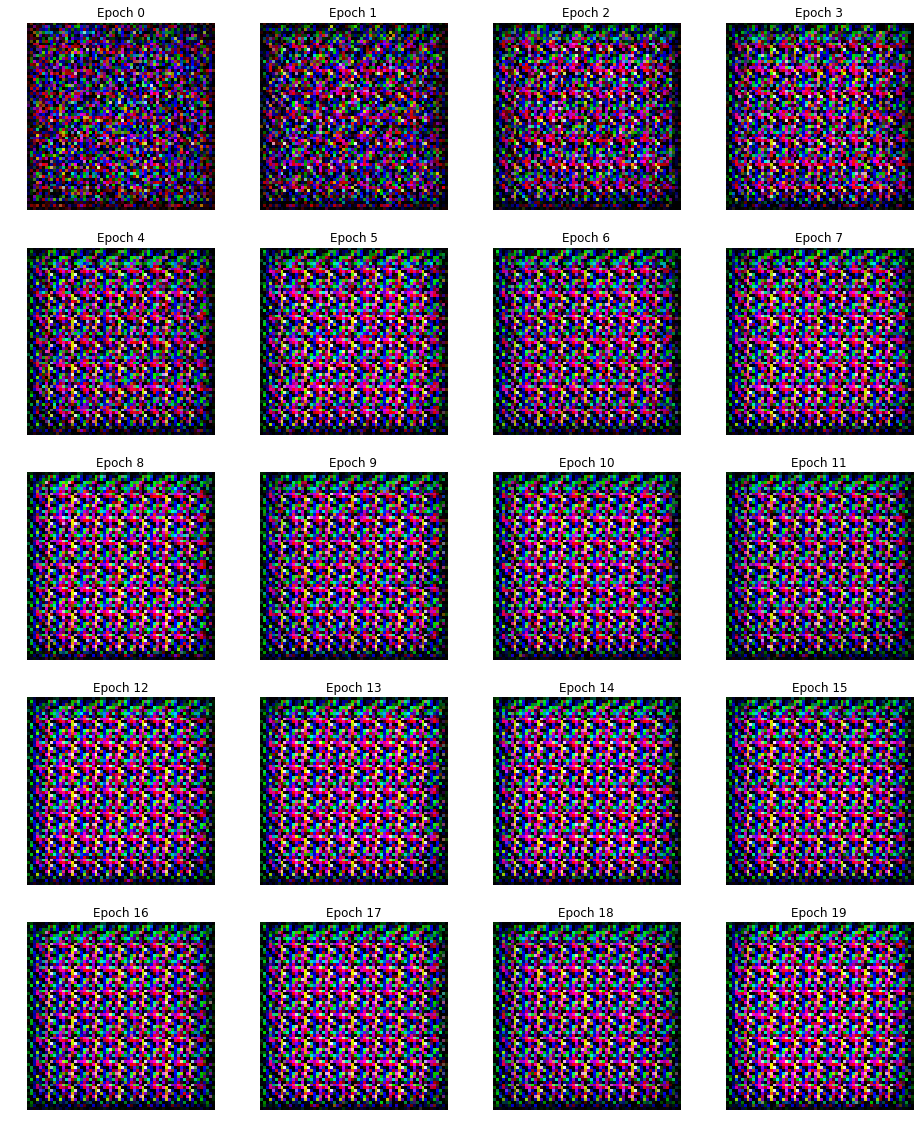

In [0]:
learner.fit(20, 1e-4)

It seems the output almost doesn't change with a discriminator too good since the beginning. Let's try with a higher learning rate and unfreezed batch norm layers, which accidentally will make the critic worse initially.

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,2.407543,#na#,4.384580,2.124196,01:41
1,2.429937,#na#,4.075425,2.123237,01:39
2,2.375222,#na#,3.720347,2.115791,01:39
3,2.281655,#na#,3.393976,2.116426,01:38
4,2.201797,#na#,3.025427,2.103544,01:41
5,2.142813,#na#,2.760351,2.096511,01:39
6,2.094000,#na#,2.579896,2.089732,01:38
7,2.043452,#na#,2.358282,2.085190,01:40
8,1.984539,#na#,2.165957,2.068904,01:37
9,1.959055,#na#,2.057260,2.055759,01:39


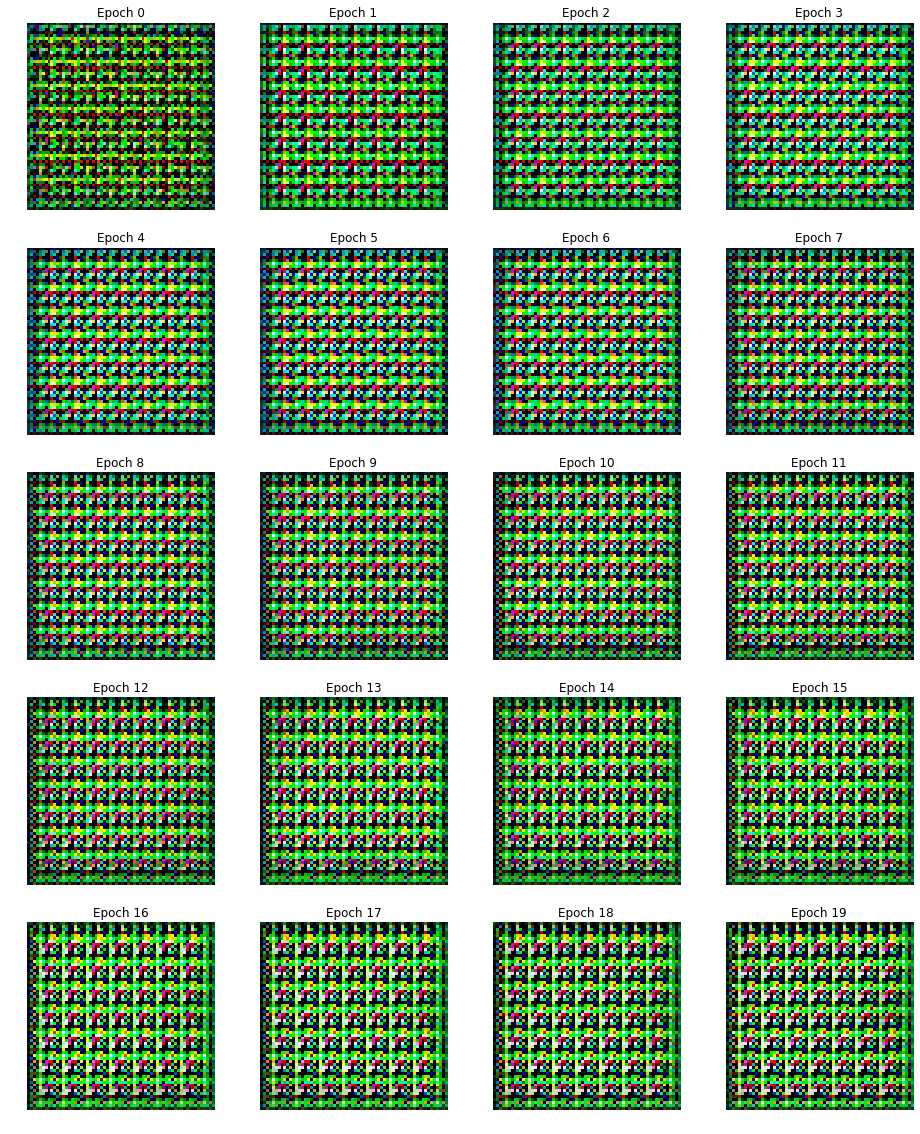

In [28]:
data = get_data(realImagesPath, 64, 64, critic_stats)
generator = GeneratorNet()
critic = load_critic()

losses = gan_loss_from_func(lambda *args: 0, nn.BCELoss(), critic.loss_func) 

learner = GANLearner(
  data,
  generator,
  critic.model,
  *losses)

learner.fit(20, 1e-3)

In [0]:
new_params = list(learner.model.critic.parameters())
compare_lists(original_params, new_params)    

In [0]:
!cat /usr/local/lib/python3.6/dist-packages/fastai/datasets.py

PENDING:

* Check if critic is reinitialized because it's giving strange predictions for real faces. The forward pass is made in LOSS_BATCH (basic_train.py). The issue seems related to model.train() -> OK, thing is in train mode (activated when fit()) the evaluation is different, as batch norm changes, because of stats, and dropout is "activated".
However, after fit is executed for **1 epoch, critic changes enough to give totally different predictions**, even if lr is really small; maybe it's caused by some stats or whatever.
* The critic is trained for receiving 224x224 images, not 64x64, and minimum input size for resnet18 is supposed to be 224x224. Resized automatically/adaptive avgpool makes it irrelevant? If not, expand generator to create 224x224 images.
* Revisit transforms (get_data)
* Find extra loss functions for generator and pass it to gan_loss_from_func. Maybe pixel loss???, feature loss???
* What if I make the final convolution a normal convolution with in_channels=out_channels (probably together with uncommenting the last ConvBlock call)? 
* Try replacing first convolution with FC layer + reshape (view)
*  Further research about that first layer "project and reshape"
* Use pretrained critic AND generator. For the generator, train to generate images from a different dataset than the one used for training the GAN.

FACTS:

* Critic is giving strange predictions for real faces. Thing is in train mode (activated with model.train() when fit()) the evaluation is different, as batch norm changes, because of stats, and dropout is "activated".
However, after fit is executed for **1 epoch, critic changes enough to give totally different predictions** in eval mode, even if lr is really small; maybe it's caused by some stats or whatever.
The forward pass is made in LOSS_BATCH (basic_train.py).
* Using only a pretrained critic might be a bad idea, especially thinking about the gradients used by the generator to improve.
